
## Necessary imports (to compute only once)

In [1]:
import pandas as pd
import numpy as np
import haversine as hs
import folium
import matplotlib.cm as cm
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import copy
import math
import random
import time
import datetime

## Useful functions (to compute only once)

In [2]:
#Getting the data from the Instances files

def open_excel_employees(file):
    #open and reads the excel with the employees list
    df_employee=pd.read_excel(file,sheet_name="Employees")
    return df_employee

def open_excel_employees_unav(file):
    #open and reads the excel with the employees unavailabilities list
    df_employee_unav=pd.read_excel(file,sheet_name="Employees Unavailabilities")
    return df_employee_unav

def open_excel_tasks(file):
    #open and reads the excel with the task list
    df_tasks=pd.read_excel(file,sheet_name="Tasks")
    return df_tasks

def open_excel_tasks_unav(file):
    #open and reads the excel with the task unavailabilities list
    df_tasks_unav=pd.read_excel(file,sheet_name="Tasks Unavailabilities")
    return df_tasks_unav

def main(path):
    #returns the four dataframes
    employees=open_excel_employees(path)
    employees_unav=open_excel_employees_unav(path)
    tasks=open_excel_tasks(path)
    tasks_unav=open_excel_tasks_unav(path)
    return employees, employees_unav, tasks, tasks_unav

In [3]:
#We compute all times in minutes after midnight, since the tasks changes everyday
def convert_time_to_minute(dt):
    #converting a datetime string to minutes
    return dt.hour*60+dt.minute

#We compute all times in minutes after midnight, since the tasks changes everyday
def convert_time_to_minute(dt):
    #converting a datetime string to minutes
    return dt.hour*60+dt.minute


def fill_classes(employees,employees_unav, tasks, tasks_unav):
    dic=dict()
    A = []
    T = []
    
    idx_agent=1
    dic_agent=dict()
    for agent in employees.EmployeeName.unique():
            
    #Filling agent:
            
        name = idx_agent

        #home coords: 
        sub_df=employees[employees.EmployeeName==agent]  
        home_coords = (sub_df.Latitude.iloc[0], sub_df.Longitude.iloc[0] )

        #level:
        level = sub_df.Level.iloc[0] 

        #unvailable: 
        unavail=[]
        sub_df2= employees_unav[employees_unav.EmployeeName==agent]
        for row in sub_df2.itertuples():
            unavail.append((convert_time_to_minute(pd.to_datetime(row.Start)), convert_time_to_minute(pd.to_datetime(row.End)), (row.Latitude, row.Longitude) ))
        #start, end and tasks
        start = convert_time_to_minute(pd.to_datetime(sub_df.WorkingStartTime.iloc[0]))
        end = convert_time_to_minute(pd.to_datetime(sub_df.WorkingEndTime.iloc[0]))
        tasks_class= []
        a=Agent(name, home_coords, level, unavail, start, end, tasks_class)
        A.append(a)
        dic_agent[idx_agent]=agent
        idx_agent+=1
        
     
    
    
    number_task=1   
    for task in tasks.TaskId.unique():  
        
    #Filling Tasks
            
        #number:
        number = number_task

        #coords
        sub_df3 =  tasks[tasks.TaskId==task]
        coords = (sub_df3.Latitude.iloc[0], sub_df3.Longitude.iloc[0] )

        #level
        level = sub_df3.Level.iloc[0] 

        #duration
        duration = sub_df3.TaskDuration.iloc[0]

        #unavailability
        unavail2=[]
        sub_df4= tasks_unav[tasks_unav.TaskId==task]

        for row in sub_df4.itertuples():
            unavail2.append((convert_time_to_minute(pd.to_datetime(row.Start)), convert_time_to_minute(pd.to_datetime(row.End)) ))
        t= Task(number, coords, level, unavail2, duration ) 
        T.append(t)
        number_task+=1
        
    #putting in dictionnary
    dic["Agents"]=A
    dic["Tasks"]=T
    
    return dic, [i for i in range(len(dic['Tasks']))],[i for i in range(len(dic['Agents']))], dic_agent
            


In [4]:
class Agent():
    
    def __init__(self, idx, home_coords, level, unavail, start, end, tasks, schedule = {}):
        
        self.idx = idx
        self.home_coords = home_coords
        self.level = level
        self.unavail = unavail
        self.start = start
        self.end = end
        self.tasks = tasks
        self.schedule = schedule
        #
        if self.schedule == {} :
            self.schedule = [(start, home_coords)]

            for i in range(len(unavail)):
                self.schedule += [(unavail[i][0],unavail[i][2]),(unavail[i][1],unavail[i][2])]

            self.schedule += [(end, home_coords)]
            
            for i in range(len(self.schedule)):
                if self.schedule[i][0] > 780 :
                    self.schedule = self.schedule[:i] + [(780, (0,0)),(840, (0,0))] + self.schedule[i:]
                    break

            
    def task_avail_bool(self, new_task):
        """
        Allows you to know if a task "fits into an availability slot".
        
        Parameters
        ---------------
        self (method), and new_task objects considered
        
        Return
        ---------------
        a list of pairs indicating a boolean with the index of the considered availability slot
        there will therefore be a pair for each availability slot of the agent. True will indicate that we can
        the task can be "entered" into the slot! This is also where the levels are taken into account
        
        """
        list_avail_bool = [(i, False) for i in range(len(self.schedule)//2)]
        
        for i in range(len(self.schedule)//2):
            
            avail = [self.schedule[2*i],self.schedule[2*i+1]]
            #we check if the avail start with the end of the lunch break, and assume that the lunch break occured in the place of the last task done
            if avail[0][1] == (0,0):
                begin_time, begin_place = avail[0][0], self.schedule[2*i - 2][1]
            else :
                begin_time, begin_place = avail[0][0], avail[0][1]
            #we check if the avail end with the start of the lunch break, and assume that the lunch break will occur in the place of the next task done
            if avail[1][1] == (0,0):
                end_time, end_place = avail[1][0], self.schedule[2*i+3][1]
            else :
                end_time, end_place = avail[1][0], avail[1][1]
            
            #computation of the time to go to the new task or to leave from the new tasks to arrive at the place at the end of the availability
            travel_begin_task = math.ceil(hs.haversine(begin_place, new_task.coords)*(6/5))
            travel_end_task = math.ceil(hs.haversine(new_task.coords, end_place)*(6/5))
            
            #check if the level of the agent is enough to take care of the task
            if (self.level >= new_task.level):
                #check if we have the time to go to the task, to do the task, and to leave from the task to go to the place at the end of the unavailability
                if begin_time + travel_begin_task + travel_end_task + new_task.duration <= end_time: 
                    #the task fits the employee availability gap
                    if len(new_task.unavailability) == 0 : 
                        #the task doesn't have unavailabilities, we can start the task immediatly after the travel
                        list_avail_bool[i] = (i, True, begin_time + travel_begin_task)
                    else : 
                        #the task have unavailabilities
                        #we assume the task has only one unavailability 
                        begin_unav_task = new_task.unavailability[0][0]
                        end_unav_task = new_task.unavailability[0][1]
                        if begin_time + travel_begin_task + new_task.duration <= begin_unav_task : 
                            #we can do the task before the unavailability
                            list_avail_bool[i] = (i, True, begin_time + travel_begin_task)
                        elif travel_begin_task + begin_time >= end_unav_task :
                            #we can do the task after the unavailability
                            list_avail_bool[i] = (i, True, begin_time + travel_begin_task)
                            
        return list_avail_bool
                            
        
        
        
    def update(self, new_task, avail):
        """
        Allows you to permanently assign a task to an agent and to modify its schedule and tasks attributes accordingly
        
        Parameters
        ----------------
        self (method)
        new_task, the new task to add
        avail an element of the list_avail_bool
        
        Return
        ----------------
        an update of self with the schedule modified accordingly
        
        """
        x = copy.deepcopy(self.schedule)
        
        self.schedule= x[:2*avail[0]+1] + [(avail[2], new_task.coords, new_task.number), (avail[2] + new_task.duration, new_task.coords, new_task.number)] + x[2*avail[0]+1:]
        
        self.tasks.append(new_task.number)
        
        return Agent(self.idx, self.home_coords, self.level, self.unavail, self.start, self.end, self.tasks, self.schedule)
        
    def delete(self, old_task) :
        """
        Allows you to permanently delete a task from an agent and to modify its schedule and tasks attributes accordingly
        
        Parameters
        ----------------
        self (method)
        new_task, the old task to delete
        
        Return
        ----------------
        an update of self with the schedule modified accordingly
        
        """
        element_to_delete = []
        
        for i in range(len(self.schedule)) :
            if len(self.schedule[i]) == 3 :
                if self.schedule[i][2] == old_task.number :
                    element_to_delete.append(self.schedule[i])
                    
        for element in element_to_delete :
            
            self.schedule.remove(element)

        self.tasks.remove(old_task.number)
        
        
        return Agent(self.idx, self.home_coords, self.level, self.unavail, self.start, self.end, self.tasks, self.schedule)

In [5]:
class Task():
    
    def __init__(self, number, coords, level, unavailability, duration, idx_agent = None):
        self.number = number - 1
        self.coords = coords
        self.level = level
        self.unavailability = unavailability
        self.duration = duration
        self.idx_agent = idx_agent
        
    def update(self, idx_agent):
        self.idx_agent = idx_agent
        return Task(self.number + 1, self.coords, self.level, self.unavailability, self.duration, self.idx_agent)
    

In [6]:
def copy_parfaite(situation): 
    """
    Parameters
    -----------------
    takes as input a dictionary with two keys, 'agent' and 'task', containing the agents and tasks of the current situation
    
    Return 
    -----------------
    an identical situation (without any side effects)
    
    """
    new_situation = dict()
    agents = []
    for agent in situation['Agents']:
        a = copy.deepcopy(agent)
        agents.append(a)
        
    tasks = []
    for task in situation['Tasks']:
        t = copy.deepcopy(task)
        tasks.append(t)
        
    new_situation['Agents'] = agents
    new_situation['Tasks'] = tasks
    
    return new_situation

In [7]:
def get_cost(situation):
    """
    Parameters
    -----------------
    takes as input a dictionary with two keys, 'agent' and 'task', containing the agents and tasks of the current situation
    
    Return 
    -----------------
    the value of the goal for the above situation
    
    """
    
    task_list = situation['Tasks']
    agent_list = situation['Agents']
    sum_duration = 0
    sum_transportation = 0 
    alpha_1 = 0.8
    alpha_2 = 0.08
    
    for task in task_list :
        
        if task.idx_agent != None :
            sum_duration += task.duration
    
    for agent in agent_list :
        sched = copy.deepcopy(agent.schedule)
        sched.remove((780, (0,0)))
        sched.remove((840, (0,0)))
        for i in range(len(sched)-1):
            sum_transportation += math.ceil(hs.haversine(sched[i][1], sched[i+1][1])*(6/5)) 
            
     
    return - alpha_1*sum_duration + alpha_2*sum_transportation

In [8]:
def get_neighbors(situation, task_idx, agent_idx):
    """
    Parameters
    -----------------
    takes as input a dictionary of the current situation, and an index of the task to be considered for the creation of neighbors
    
    Return 
    -----------------
    A list of neighbor situations for a change of location of the considered task
    
    """
    neighbors = []
    
    situation_copy = copy_parfaite(situation)
    task = situation_copy['Tasks'][task_idx]
    current_agent_idx = task.idx_agent
    if current_agent_idx != None :
        current_agent = situation_copy['Agents'][current_agent_idx]
        r = current_agent.delete(task)
        situation_copy['Agents'][current_agent_idx] = r
        
    agent = situation_copy['Agents'][agent_idx]
    list_avail = agent.task_avail_bool(task)
    for avail in list_avail :
        
        if avail[1] :
            situation_copy_2  = copy_parfaite(situation_copy)

            y = copy.deepcopy(situation_copy_2['Agents'][agent_idx])
            situation_copy_2['Agents'][agent_idx] = y.update(task, avail)
            
            z = copy.deepcopy(situation_copy_2['Tasks'][task_idx])
            situation_copy_2['Tasks'][task_idx] = z.update(agent_idx)
            neighbors.append(situation_copy_2)
       
    return neighbors
                      

In [9]:
def simulated_annealing(initial_state, task_list_idx, agent_list_idx, n):
    """Peforms simulated annealing to find a solution"""
    initial_temp = n
    final_temp = 0
    alpha = 0.01
    
    current_temp = initial_temp

    # Start by initializing the current state with the initial state
    current_state = initial_state
    
    while current_temp > final_temp :
        task_idx = random.choice(task_list_idx)
        agent_idx = random.choice(agent_list_idx)
        neighbor_list = get_neighbors(current_state, task_idx, agent_idx)
        if len(neighbor_list) != 0 :
            neighbor = random.choice(neighbor_list)
        # Check if neighbor is best so far
            cost_diff = get_cost(current_state) - get_cost(neighbor)
        # if the new solution is better, accept it
            if cost_diff > 0:
                current_state = copy_parfaite(neighbor)
        # if the new solution is not better, accept it with a probability of e^(-cost/temp)
            else:
                if random.uniform(0, 1) < math.exp(-cost_diff / current_temp):
                    current_state = copy_parfaite(neighbor)
        # decrement the temperature
        current_temp -= alpha
      

    solution = current_state
    
    return solution, get_cost(solution)


The following cells are to be executed each time you want to test the model on new Instances. 

## Getting the data

In [11]:
#Ask user to chose for instance

print("Hello !!!\n")
print("The different data sets for this metaheuristic version are :\n")
print("Instances V2 :\n")
print("1 - Australia\n")
print("2 - Austria\n")
print("3 - Poland\n")
print("4 - Bordeaux\n")
print("5 - Spain\n")

print("Instances V3 :\n")

print("6 - Columbia\n")
print("7 - Ukraine\n")
print("8 - Romania\n")



set_chosen = int(input("Enter a number between 1 and 8\n"))
if set_chosen<1 or set_chosen>8:
    print("error no set available")
    

sets = { 1: "Australia", 2: "Austria", 3: "Poland", 4: "Bordeaux", 5 : "Spain", 6:"Columbia", 7:"Ukraine", 8:"Romania"}
if set_chosen <=5:
    choice= "../data/InstancesV2/Instance" +sets[set_chosen]+"V2.xlsx"
else:
    choice= "../data/InstancesV3/Instance" +sets[set_chosen]+"V3.xlsx"
employees,  employees_unav, tasks, tasks_unav = main(choice)

employees.columns = ['EmployeeName', 'Latitude', 'Longitude', 'Skill', 'Level', 'WorkingStartTime', 'WorkingEndTime']

display(employees.head(5))
display(employees_unav)
display(tasks.head(10))
display(tasks_unav)


Hello !!!

The different data sets for this metaheuristic version are :

Instances V2 :

1 - Australia

2 - Austria

3 - Poland

4 - Bordeaux

5 - Spain

Instances V3 :

6 - Columbia

7 - Ukraine

8 - Romania



,EmployeeName,Latitude,Longitude,Skill,Level,WorkingStartTime,WorkingEndTime
0,Juan,5.727388,-72.914110,Oenology,2,8:00am,6:00pm
1,Maria,5.327109,-71.049204,Oenology,1,8:00am,6:00pm
2,Carolina,5.182377,-71.159168,Oenology,3,8:00am,6:00pm
3,Javier,5.437072,-71.326507,Oenology,3,8:00am,6:00pm
4,Ana,6.461574,-71.528222,Oenology,2,8:00am,6:00pm


,EmployeeName,Latitude,Longitude,Start,End
0,Juan,5.727388,-72.914110,8:00am,9:00am
1,Javier,5.437072,-71.326507,4:00pm,6:00pm
2,Daniel,4.960921,-71.055230,11:00am,11:45am


,TaskId,Latitude,Longitude,TaskDuration,Skill,Level,OpeningTime,ClosingTime
0,T1,5.373067,-71.236704,150,Oenology,2,8:00am,6:00pm
1,T2,4.989968,-71.126165,120,Oenology,2,8:00am,6:00pm
2,T3,4.989968,-71.126165,90,Oenology,2,8:00am,6:00pm
3,T4,5.449599,-71.525149,40,Oenology,2,8:00am,6:00pm
4,T5,6.448600,-71.160019,40,Oenology,1,8:00am,6:00pm
5,T6,5.994263,-70.985982,40,Oenology,2,8:00am,6:00pm
6,T7,6.217975,-71.261520,90,Oenology,2,8:00am,6:00pm
7,T8,5.187847,-70.704248,45,Oenology,2,8:00am,6:00pm
8,T9,5.141344,-70.748059,45,Oenology,1,8:00am,6:00pm
9,T10,5.178808,-71.476724,45,Oenology,3,8:00am,6:00pm


,TaskId,Start,End
0,T58,8:00am,10:00am
1,T73,2:00pm,2:30pm
2,T86,3:00pm,6:00pm
3,T103,11:00am,12:00pm


In [13]:
dic, task_list_idx, agent_list_idx, dic_agent = fill_classes(employees,employees_unav, tasks, tasks_unav)
#dic_glouton=solution_glouton(dic, task_list_idx,agent_list_idx)

In [14]:
n = 100
t_0 = time.time()
solution, cost_solution = simulated_annealing(dic, task_list_idx, agent_list_idx, n)

exec_time = time.time() - t_0
print("execution time :", exec_time)
print(n*100, "itérations")
print("objective function :", cost_solution)

execution time : 56.281672954559326
10000 itérations
objective function : -1547.92


In [15]:
for i in range(len(solution['Agents'])):
    print("L'emploi du temps de l'agent "+ dic_agent[solution['Agents'][i].idx]+":  ", solution['Agents'][i].schedule)
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

L'emploi du temps de l'agent Juan:   [(480, (5.7273878, -72.91411049999999)), (480, (5.7273878, -72.91411049999999)), (540, (5.7273878, -72.91411049999999)), (591, (6.002534, -73.172325), 53), (631, (6.002534, -73.172325), 53), (640, (6.052988, -73.205928), 44), (670, (6.052988, -73.205928), 44), (780, (0, 0)), (840, (0, 0)), (914, (6.505896, -72.89080600000001), 74), (954, (6.505896, -72.89080600000001), 74), (1080, (5.7273878, -72.91411049999999))]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
L'emploi du temps de l'agent Maria:   [(480, (5.327108900000001, -71.0492036)), (528, (5.141344, -70.748059), 8), (573, (5.141344, -70.748059), 8), (610, (4.949382, -70.945437), 26), (650, (4.949382, -70.945437), 26), (685, (4.94, -71.202565), 20), (730, (4.94, -71.202565), 20), (780, (0, 0)), (840, (0, 0)), (857, (4.87193, -71.041117), 34), (897, (4.87193, -71.041117), 34), (977, (5.465173, -71.11959300000001), 17), (1017, (5.465173, -71.11959300000001), 17), (1024, (5.432972, -71.08

In [16]:
def return_solution(dic, dic_agent):
    #Output formatting
    if set_chosen >5:
        name="Solutions/Text/Solution"+sets[set_chosen]+"V3"+"By3.txt"
    else:
        name="Solutions/Text/Solution"+sets[set_chosen]+"V2"+"By3.txt"
    f = open(name, "w")
    f.write("taskId;performed;employeeName;startTime;\n")
    for task1 in dic["Tasks"]:
        performed=0
        for agent in dic["Agents"]:
            if task1.number in agent.tasks:
                             
                for element in agent.schedule:
                    
                    if len(element)==3:
                        if element[2]==task1.number:
                            startTime=element[0]
                            performed=1
                            employeeName=dic_agent[agent.idx]
                            break
                    else: pass
        
        if performed == 1:
            best_solution = str(task1.number + 1)+";"+ str(performed)+";"+ str(employeeName) + ";" + str(startTime)+";\n"
            f.write(best_solution)  
        if performed ==0:
            best_solution = str(task1.number + 1)+";"+ str(performed) +";;;\n"
            f.write(best_solution) 
    f.close()
        

return_solution(solution, dic_agent)

In [17]:
#To produce the path of the employees on a map
center = solution['Agents'][0].schedule[0][1]
Map = folium.Map(location=center, zoom_start=8)

for task in solution['Tasks']:
    folium.Marker(location=task.coords, popup='T'+str(task.number + 1), icon=folium.Icon(color="blue", icon="glyphicon glyphicon-wrench") ).add_to(Map) 
    
lgd_txt = '<span style="color: {col};">{txt}</span>'
   
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']*10
count=-1
for agent in solution['Agents']:
    c=0
    for unav in agent.unavail:
        folium.Marker(location=unav[2], popup='Indispo_'+dic_agent[agent.idx]+'_'+str(c), icon=folium.Icon(color="purple", icon="glyphicon glyphicon-ban-circle") ).add_to(Map) 
        c+=1
    count+=1
    color=colors[count]
    feature_group = folium.FeatureGroup(name= lgd_txt.format( txt= dic_agent[agent.idx], col= color)) #legend
    sch=agent.schedule
    folium.Marker(location=sch[0][1], popup='Maison_'+dic_agent[agent.idx], icon=folium.Icon(color='red', icon="home")).add_to(feature_group) #lieu de sa maison
    pl= folium.PolyLine([sch[0][1]]+[sch[i][1] for i in range(len(sch)) if sch[i][1] != (0,0)]+[sch[0][1]], color=color)
    pl.add_to(feature_group)
    feature_group.add_to(Map)

folium.LayerControl().add_to(Map) 
if set_chosen >5:
    Map.save('Solutions/Map/map_'+sets[set_chosen]+'V3_meta.html')
else:
    Map.save('Solutions/Map/map_'+sets[set_chosen]+'V2_meta.html')
Map

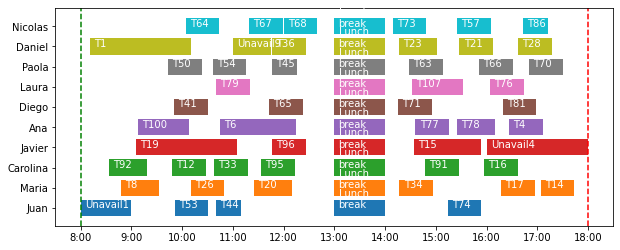

In [18]:
#To produce the visual timetable in png format

fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
data = {}

for agent in solution['Agents']:
    sch=agent.schedule
    for i in range(1,(len(sch)//2)):
        if len(sch[2*i-1])>2:
            data['T'+str(sch[2*i-1][2])]= (sch[2*i-1][0], sch[2*i][0], dic_agent[agent.idx])
    data['Lunch \nbreak' + str(agent.idx)] = (780, 840, dic_agent[agent.idx])
    
    if agent.unavail != []:
        data['Unavail' + str(agent.idx)] = (agent.unavail[0][0], agent.unavail[0][1], dic_agent[agent.idx])

cats = {dic_agent[solution['Agents'][i].idx]:i for i in range(len(solution['Agents']))}
colormapping = {dic_agent[solution['Agents'][i].idx]:"C"+str(i) for i in range(len(solution['Agents']))}

verts = {dic_agent[solution['Agents'][i].idx]:[] for i in range(len(solution['Agents']))}
colors = {dic_agent[solution['Agents'][i].idx]:[] for i in range(len(solution['Agents']))}
for task, times in data.items():
    v =  [(times[0], cats[times[2]]-.4),
          (times[0], cats[times[2]]+.4),
          (times[1], cats[times[2]]+.4),
          (times[1], cats[times[2]]-.4),
          (times[0], cats[times[2]]-.4)]
    verts[times[2]].append(v)
    colors[times[2]].append(colormapping[times[2]])
    ax.annotate(task[:12], (times[0]+5, cats[times[2]]), color='w')

for cat in verts.keys():
    bars = PolyCollection(verts[cat], facecolors=colors[cat])
    ax.add_collection(bars)
    
ax.set_yticks([i for i in range(len(solution['Agents']))])
ax.set_yticklabels([dic_agent[solution['Agents'][i].idx] for i in range(len(solution['Agents']))])
ax.set_xticks([i for i in range(480,1140, 60)])
ax.set_xticklabels([str(datetime.timedelta(minutes=i))[:-3] for i in range(480,1140, 60)])

ax.axvline(x = 480, color = "green", linestyle='--', label = "Start of the day") 
ax.axvline(x = 1080, color = "red", linestyle='--', label = "End of the day") 
ax.autoscale()
if set_chosen >5:
    plt.savefig('Solutions/Timetable/timetable_'+sets[set_chosen]+'V3_meta.png', transparent=True)
else:
    plt.savefig('Solutions/Timetable/timetable_'+sets[set_chosen]+'V2_meta.png', transparent=True)